# Using Natural Language Processing to predict suicidal ideation on Reddit

## Introduction
Suicide is one of the leading causes of death globally, with an estimate of 800,000 annually. That is one person every 40 seconds (WHO, 2014). A key aspect in suicide prevention is addressing suicidal thoughts before they become actions. With an ever increasing number of internet, social media platforms have become a space where people share about their daily lives, and this include emotions and hardships. A recent US study has shown a strong positive correlation between the proportion of the tweets containing suicide risk factors with rates of age-adjusted suicide rates in the US. This means that even suicidal thoughts are posted in social media platforms. 

In this analysis, we use multiple techniques of natural language processing to classify suicidal and non-suicidal thoughts. We then compare the techniques to decide which one performs better. 

## About the data
In this notebook, we used the data collected from Reddit's "SuicideWatch" and "teenagers" subreddits using PushShift API. The data collected is from December 16, 2008 to January 1, 2021. Please find the dataset [here](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch)

## Setup

In [27]:
# Import libraries and helper functions
import warnings
warnings.filterwarnings('ignore')
from utils import *

In [28]:
# Read in data
data_path = "~/Desktop/Work/Github/_data/Suicide_Detection.csv"
reddit_data = pd.read_csv(data_path, index_col = 0).reset_index(drop=True)
reddit_data.sample(5, random_state= 1)  # peak at a random sample of 5 rows

,text,class
79689,I want to go to sleep and never wake upMy reas...,suicide
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide
226306,the sun is setting and it's raining i'm curren...,non-suicide
101296,Hi. Im scared. Plz talk to me.Private message,suicide
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide


In [29]:
reddit_data.info()      # data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


The dataset has two columns, both in correct data types and there are no missing values.

## Initial Text Analysis

### Distribution of target variable classes

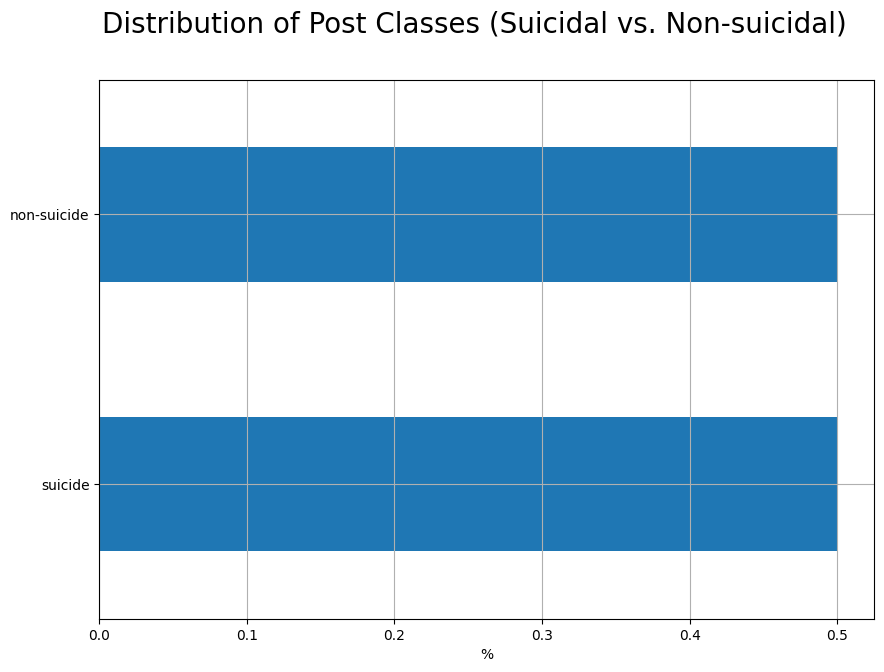

In [30]:
# Evaluate distribution of post classes (target variable)
plot_distributions(data=reddit_data, x="class", figsize=(10,7), title= "Distribution of Post Classes (Suicidal vs. Non-suicidal)", 
                    xlabel="%", normalize=True)

The target variable is perfectly balanced, meaning 50% are suicidal posts while the other half is not. 

In [31]:
reddit_data = reddit_data.sample(frac=0.1, random_state=1)

### Name Entity Recognition (NER)

Additionally, Name Entity Recognition will be done below to extract more features and understand which ones are more common in reddit posts

In [32]:
# only select a few list of tags
tags_list = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]
# use spacy's NER model for news, comments, blogs
model = spacy.load("en_core_web_lg")
# append tags to dataset
reddit_data = add_ner_spacy(dtf = reddit_data, column = "text", lst_tag_filter = tags_list, create_features=True)

--- tagging ---


100%|██████████| 23207/23207 [14:10<00:00, 27.30it/s] 


--- counting tags ---


100%|██████████| 23207/23207 [00:00<00:00, 451638.89it/s]


--- creating features ---


100%|██████████| 23207/23207 [00:00<00:00, 501665.81it/s]


In [33]:
# lmake sure tags were created
reddit_data.head()

,text,class,text_tagged,tags,tags_ORG,tags_NORP,tags_EVENT,tags_GPE,tags_PERSON,tags_LOC,tags_FAC,tags_WORK_OF_ART,tags_PRODUCT
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0


Class: suicide


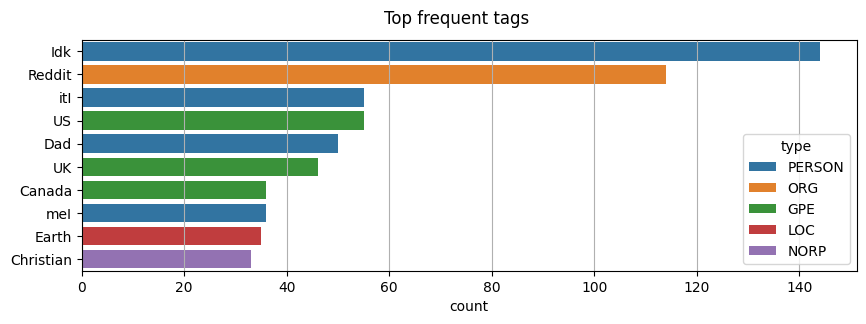

Class: non-suicide


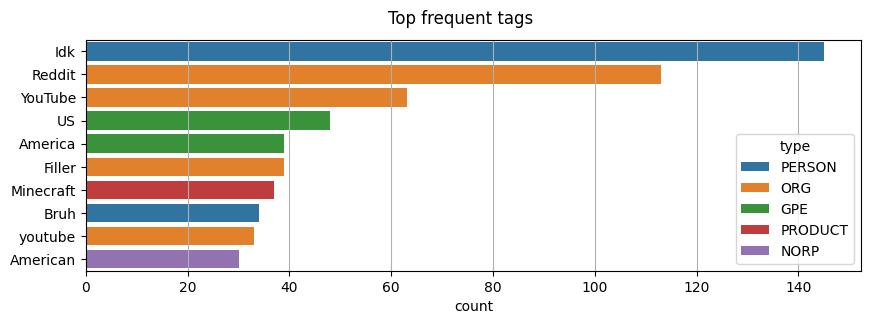

In [34]:
# Visualize tags by class
for label in reddit_data["class"].unique():
    print(f"Class: {label}")
    common_tags = plot_tags(tags=reddit_data[reddit_data["class"]== label]["tags"], top=10, figsize=(10,3))

COMMENT: Remove Reddit, idk

There seem to be no difference between the tags from suicidal and non suicidal posts for text before processing the posts. As expected Reddit comes in very often along with America and US. It looks like non-suicidal posts have more political conversations (Trump, Biden) while the suicidal posts seem to be focused on living daily life (e.g. Christian, University, NYC, UK, etc...)

In [9]:
# for x in reddit_data.filter(like="tags_", axis=1).columns:
#     plot_distributions(reddit_data, x= x, y="class", bins=None, figsize=(15,5))

### Extract more text characteristics
Features to be extracted from each post (processed text): 
- Number of words
- Number of characters
- Number of sentences
- Average word length
- Average sentence length

In [35]:
reddit_data = extract_lengths(data=reddit_data, col="text")

100%|██████████| 23207/23207 [00:02<00:00, 10819.84it/s]

Characteristics of text:

                     min        mean      max
char_count      6.000000  556.395269  31908.0
word_count      1.000000  154.816650  11620.0
sentence_count  1.000000    8.350498   1936.0
avg_word_len    1.002181    4.287735  11100.0
avg_sent_len    1.000000   24.087824   7796.0


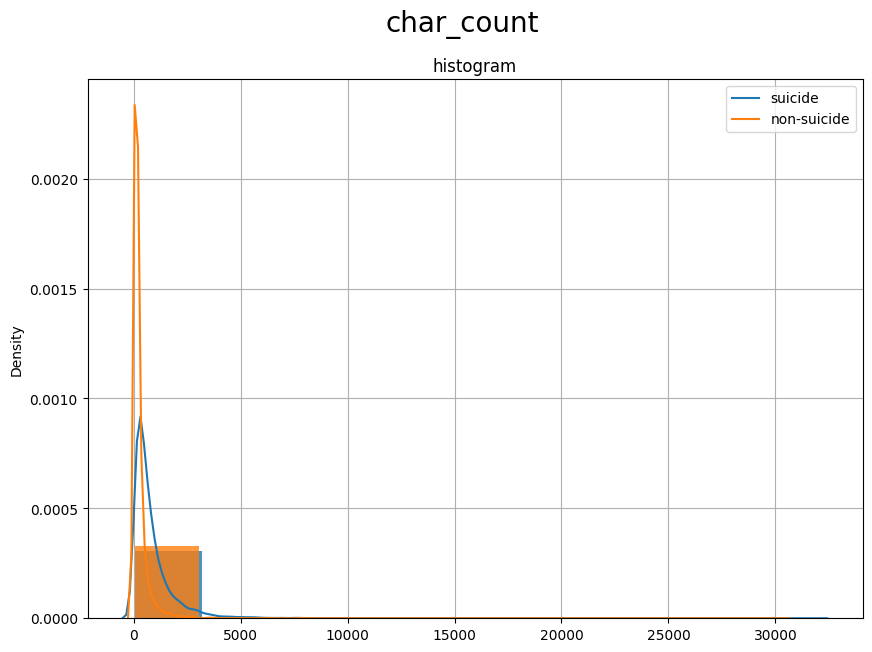

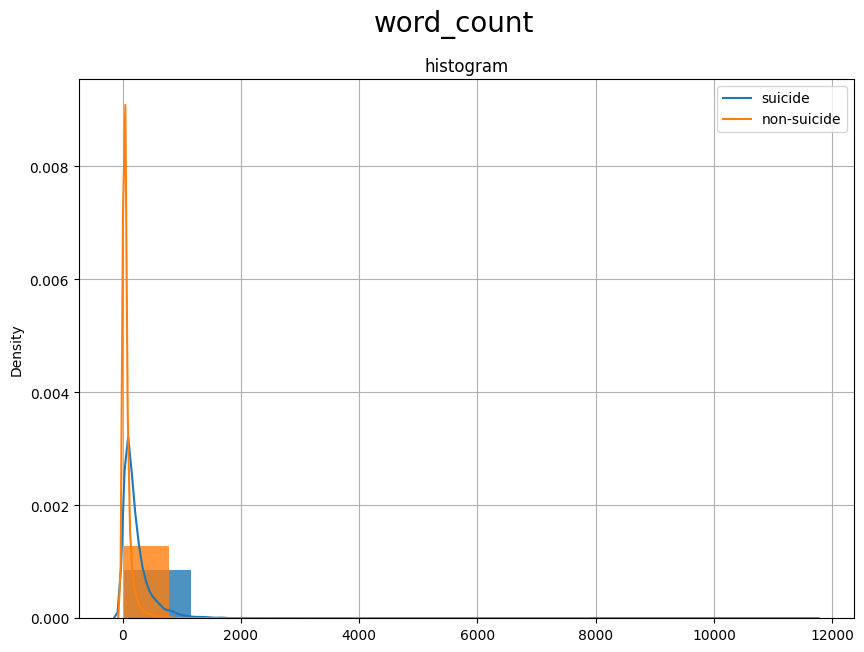

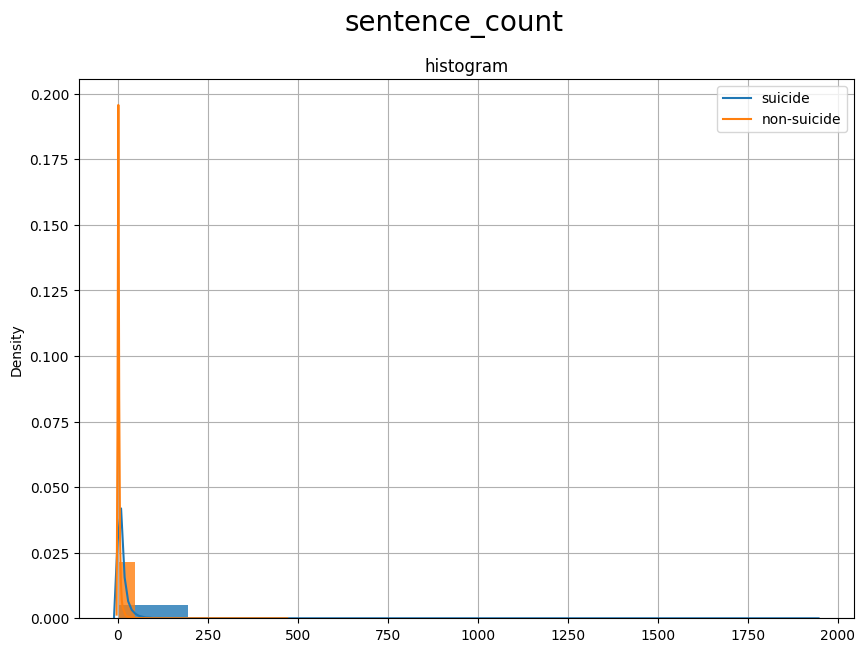

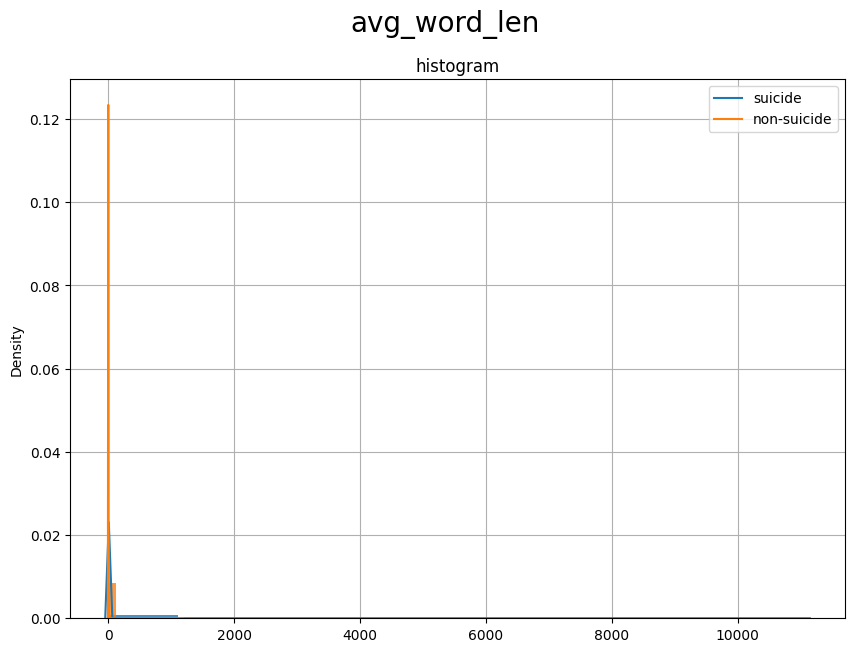

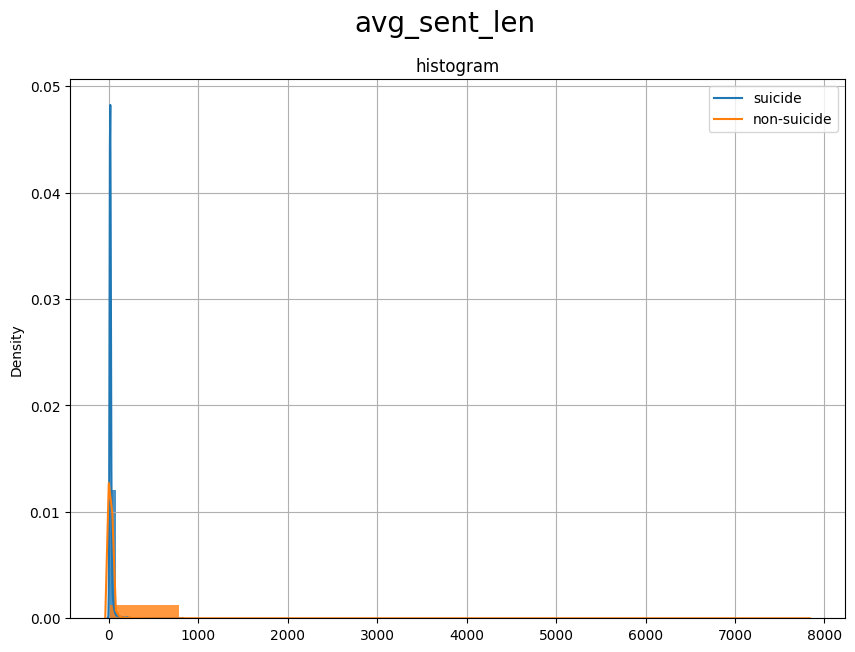

In [36]:
for col in ["char_count","word_count","sentence_count","avg_word_len","avg_sent_len"]:
    plot_distributions(reddit_data, x=col, y="class", bins=10, figsize=(10,7))

Overall, the number of characters and words in the suicidal posts tends to be higher than that in non-suicidal posts. However, the average number of words and sentences is the fairly similar between the two groups

## Text cleaning

### Remove punctuations, URLs, stopwords, and lowercase the posts

In [37]:
stopwords = stopwords_list(add_words= ["fill", "filler"])        # use default NLTK english stopwords
reddit_data = append_clean_text(reddit_data, column="text", stopwords=stopwords)

100%|██████████| 23207/23207 [00:00<00:00, 1366059.63it/s]

--- found NAs ---
                                                     text text_clean
106269                                           We’re no           
26469                              I DID IT \n\n\n\n\nNot           
55136                        this is me when the when the           
70605            it wasn't enoughhttp://imgur.com/hqERMql           
191413  I DID IT https://www.reddit.com/r/teenagers/co...           


COMMENT: urls not successfully removed

In [38]:
reddit_data.head()

,text,class,text_tagged,tags,tags_ORG,tags_NORP,tags_EVENT,tags_GPE,tags_PERSON,tags_LOC,tags_FAC,tags_WORK_OF_ART,tags_PRODUCT,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmy reasons might ma...
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0,67,309,1,4.611940,67.000000,yo done something started webtoon called doodl...
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0,29,96,2,3.310345,14.500000,sun setting raining currently listening sad po...
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi scared plz talk meprivate message
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0,283,1125,8,3.975265,35.375000,feeling hopeworthlessnessthis stupid reason fe...


### Sentiment Analysis

In [39]:
# use textblob to find sentiment for each post 
reddit_data = add_sentiment(reddit_data, "text_clean", algo="textblob", sentiment_range=(-1,1)) # sentiment for a range of -1 to 1
reddit_data.head()

100%|██████████| 23199/23199 [00:05<00:00, 4470.87it/s]

             count      mean       std  min      25%  50%       75%  max
sentiment  23199.0  0.011598  0.248898 -1.0 -0.10625  0.0  0.133922  1.0


,text,class,text_tagged,tags,tags_ORG,tags_NORP,tags_EVENT,tags_GPE,tags_PERSON,tags_LOC,tags_FAC,tags_WORK_OF_ART,tags_PRODUCT,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean,sentiment
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmy reasons might ma...,0.102143
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0,67,309,1,4.611940,67.000000,yo done something started webtoon called doodl...,0.500000
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0,29,96,2,3.310345,14.500000,sun setting raining currently listening sad po...,-0.250000
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi scared plz talk meprivate message,0.000000
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0,283,1125,8,3.975265,35.375000,feeling hopeworthlessnessthis stupid reason fe...,-0.014062


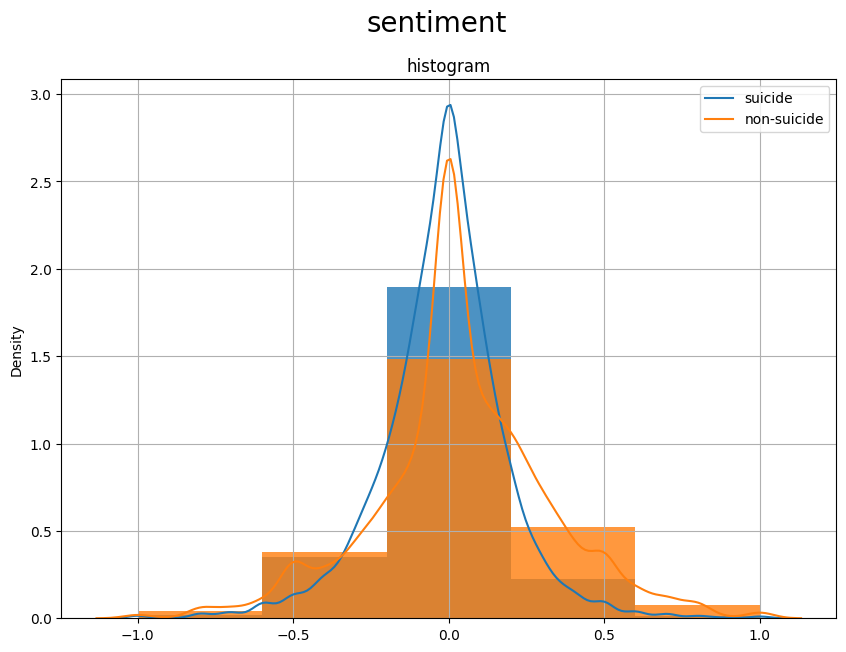

In [40]:
## Visualize sentiment 
plot_distributions(reddit_data, x="sentiment", y="class", bins=5, figsize=(10,7))

The sentiment for both suicidal and non-suicidal posts are normally distributed and overlap. There seem to be no significant difference in the sentiment between posts. 

DOES THIS MAKE SENSE? SHOULDN'T SUICIDAL POSTS HAVE A BIT LOWER SENTIMENT? INVESTIGATE USING ANOTHER SENTIMENT MEASUREMENT TECHNIQUE

# suicide:


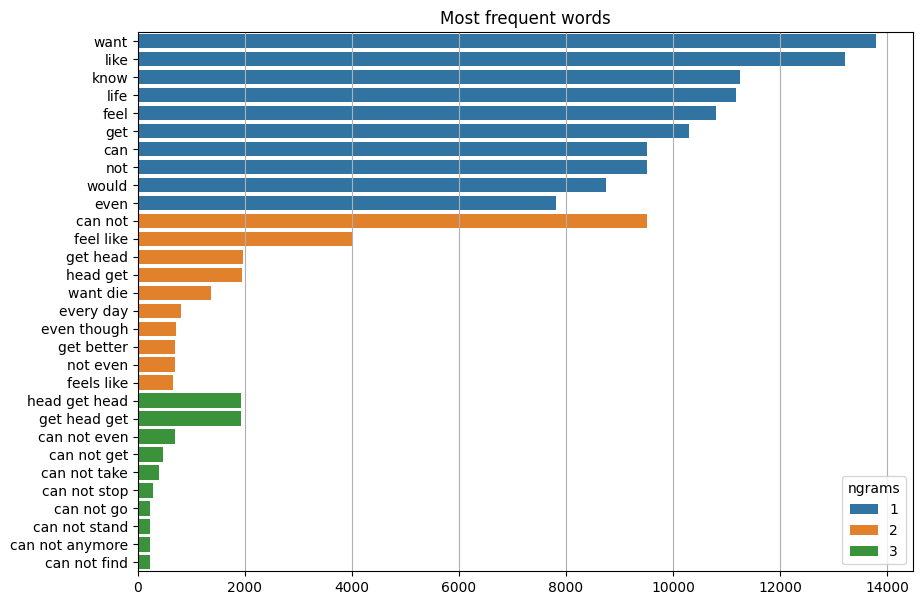

# non-suicide:


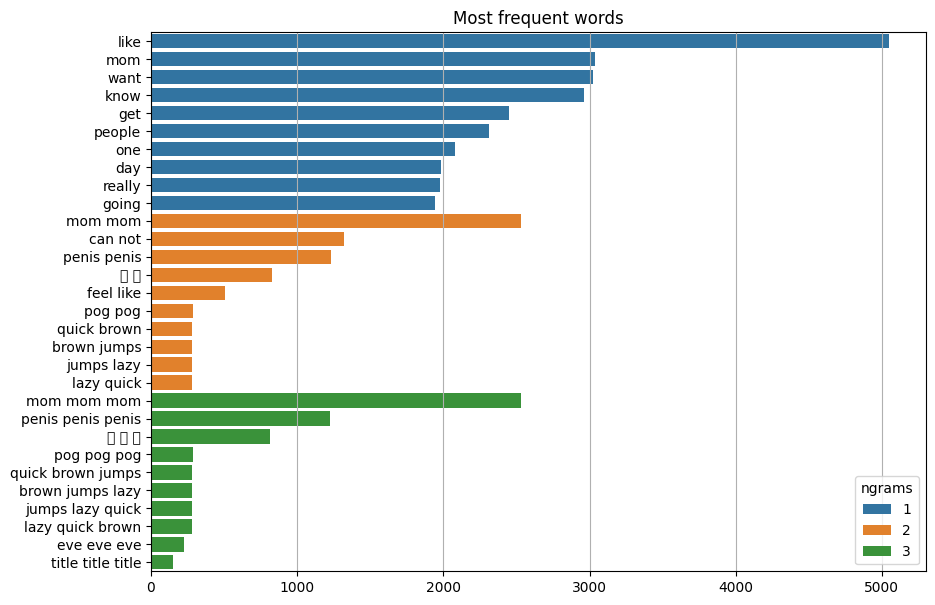

In [41]:
## Investigate the most frequent n-grams (up to 3) in clean text

dtf_freq = pd.DataFrame()
for y in reddit_data["class"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=reddit_data[reddit_data["class"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["class"] = y
    dtf_freq = dtf_freq.append(dtf_y)


more negative words in suicide (cannot, not) and more feeling words (feel, want, die)

## TODO: There are still many stop words and contraction wasn't correctly done. Please go back to this! ## Remove numbers, links


### Word Frequency and Word Could

# suicide:


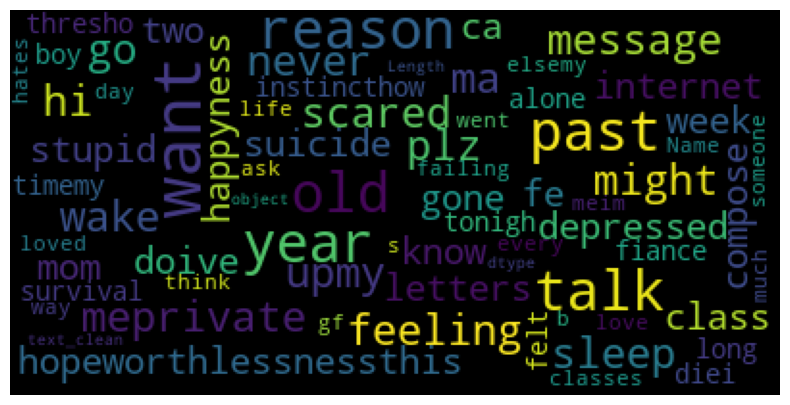

# non-suicide:


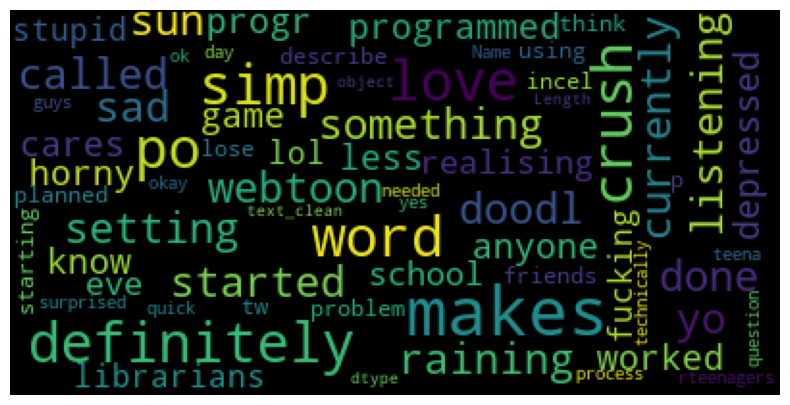

In [42]:
for y in reddit_data["class"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=reddit_data[reddit_data["class"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

COMMENT: In the suicidal word cloud we have "text_clean" which is my column name. Investigate his. Otherwise, the wordclouds between the two groups are different; the suicidal group word cloud shows more of feeling words (e.g. depression, scared, suicide, feel, thought, sleep), while the non-suicidal group word cloud is mostly non-negative feeling words. 

also remove https links

### Look at all features so far

In [43]:
reddit_data.head()

,text,class,text_tagged,tags,tags_ORG,tags_NORP,tags_EVENT,tags_GPE,tags_PERSON,tags_LOC,tags_FAC,tags_WORK_OF_ART,tags_PRODUCT,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean,sentiment
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmy reasons might ma...,0.102143
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0,67,309,1,4.611940,67.000000,yo done something started webtoon called doodl...,0.500000
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0,29,96,2,3.310345,14.500000,sun setting raining currently listening sad po...,-0.250000
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi scared plz talk meprivate message,0.000000
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0,283,1125,8,3.975265,35.375000,feeling hopeworthlessnessthis stupid reason fe...,-0.014062


## Preprocessing

### Encoding target variable

In [44]:
#mapping 1 to suicidal and 0 to non-suicidal posts
reddit_data['class'] = reddit_data['class'].map({'suicide': 1, 'non-suicide':0}) 
reddit_data = reddit_data.drop(columns=["text", "text_tagged", "tags"])

### Data partitioning

In [45]:
# define data and target for our data
X = reddit_data.drop(columns="class")
y = reddit_data["class"]

# split data in train, split sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 12)

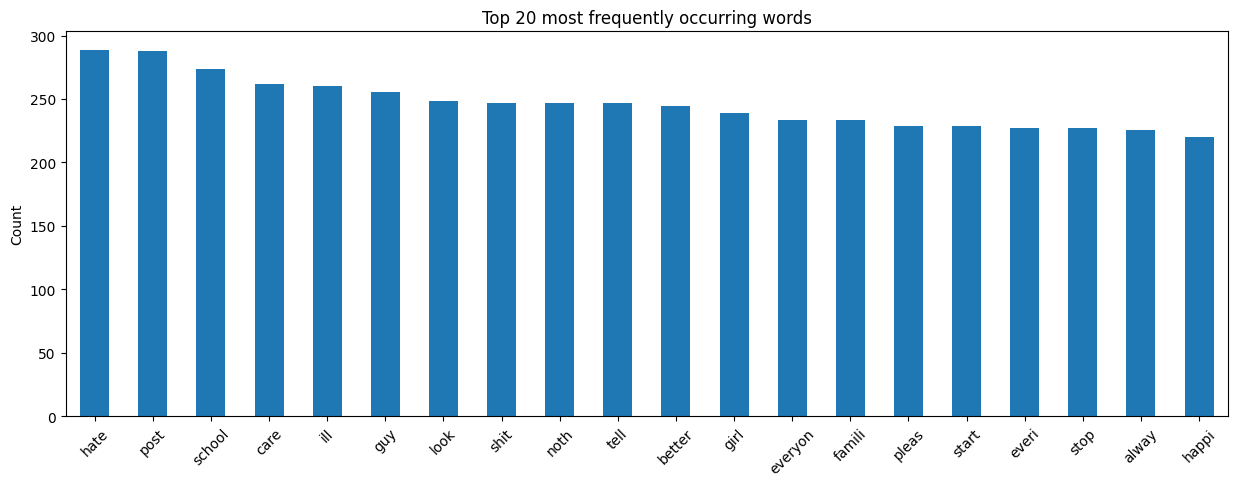

In [73]:
stemmer = nltk.stem.porter.PorterStemmer() 
bow = feature_extraction.text.TfidfVectorizer(stop_words='english', min_df=50, max_df=2000,
                                            tokenizer=lambda x: [stemmer.stem(i) for i in x.split(" ")])
bow.fit(X_train["text_clean"])
X_train_transformed = bow.transform(X_train["text_clean"])
X_test_transformed = bow.transform(X_test["text_clean"])

word_counts = pd.DataFrame({"counts": X_train_transformed.toarray().sum(axis=0)}, 
                                index=bow.get_feature_names_out()).sort_values("counts", 
                                ascending=False)

# visualize top 20 words in the train set
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title(f"Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [77]:
## join dictionary to original 
dtf_train = pd.DataFrame(columns=bow.get_feature_names_out, data=X_train_transformed.toarray(),index=X_train.index)
dtf_train.head()

TypeError: 'method' object is not iterable

In [76]:
X_train.index

Int64Index([119968, 171909, 189245, 117819,  44917,  56950,  26104, 213920,
            133710,  55066,
            ...
            213265,  83490,  32351,  87497, 207110, 172821,  86187, 160572,
            223052,  92548],
           dtype='int64', length=16239)

In [53]:
stemmer = nltk.stem.porter.PorterStemmer() 
vectorizer = feature_extraction.text.TfidfVectorizer(max_features = 1000, 
                                                    stop_words= 'english', 
                                                    tokenizer= lambda x: [stemmer.stem(i) for i in x.split(" ")])
vectorizer.fit(X_train)                                                    
X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

print(f"Shape of training matrix: {X_train_transformed.shape}")
print(f"Shape of test matrix: {X_test_transformed.shape}")

# word_counts = pd.DataFrame({"counts": X_train_transformed.toarray().sum(axis=0)}, 
#                                 index=vectorizer.get_feature_names_out()).sort_values("counts", 
#                                 ascending=False)

# # visualize top words in the train set
# if show_top is True:
    
#     word_counts.head(top).plot(kind="bar", figsize=(15, 5), legend=False)
#     plt.title(f"Top {top} most frequently occurring words")
#     plt.ylabel("Count")
#     plt.xticks(rotation=45)
#     plt.show()

Shape of training matrix: (16, 16)
Shape of test matrix: (16, 16)


Creating sparse matrices...
Shape of training matrix: (16, 16)
Shape of test matrix: (16, 16)


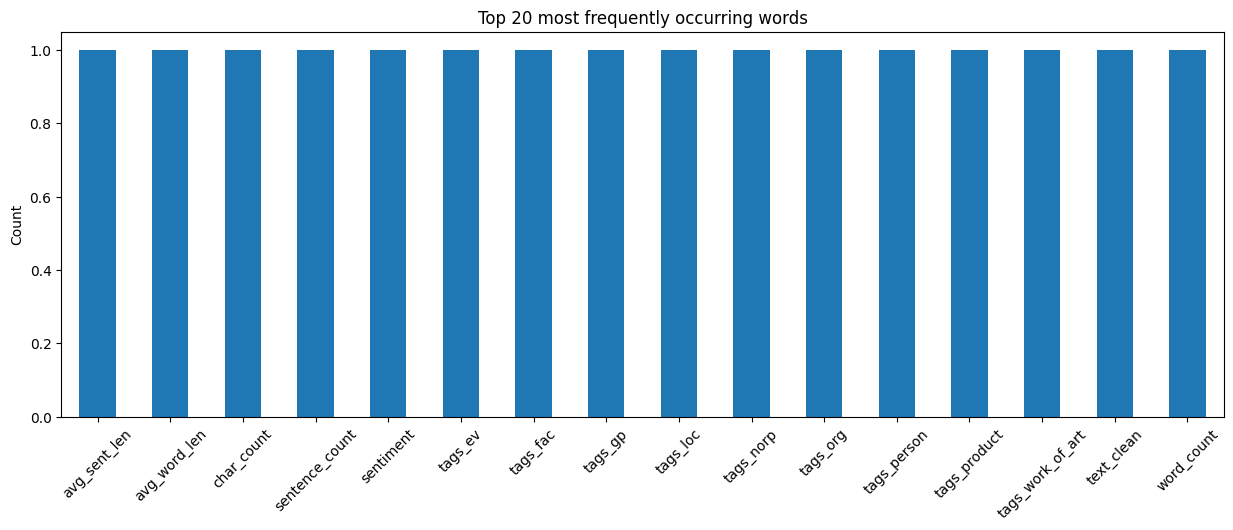

In [22]:
stemmer = nltk.stem.porter.PorterStemmer()
vectorizer = feature_extraction.text.TfidfVectorizer(min_df = 50, max_features = 1000, 
                                                    stop_words= 'english', ngram_range= (1,3), 
                                                    tokenizer= lambda x: [stemmer.stem(i) for i in x.split(" ")])
                                                    ## Add a min_df when using the larger dataframe
dic_bow = bow(X_train = X_train["text_clean"], X_test = X_test["text_clean"], vectorizer=vectorizer, top = 20, show_top=True)
X_train_transformed, X_test_transformed = dic_bow["X_train_transformed"], dic_bow["X_test_transformed"]

# join word dictionaries to original columns
X_train_transformed_df = pd.DataFrame(columns=)

In [23]:
X_train_transformed.shape

(16, 16)

## Classifiers

### Baseline Models (Bag of Words + ML models)

Before any modeling the following should be done: 
- Vectorize posts using TFIDF
- Feature Selection/Reduce Dimensions (PCA?)
- Train models: 
    - Logistic Regression
    - KNN 
    - Decision Tree
    - XGBoost 
    - Random Forest 
    - SVM 
- Choose top 3 models based on accuracy
- Parameter optimization for top 3 models
- Precision/Recall for evaluation
- Train a NN (Transfer learning?)
- Choose model based on accuracy, explainability, and computation time

Maybe make a flowchart for this process for better understanding?


### Logistic Regression

Read more about confusion matrix after cross validation at [cross validation](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874)

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      1.00      0.86        12

    accuracy                           0.75        16
   macro avg       0.38      0.50      0.43        16
weighted avg       0.56      0.75      0.64        16



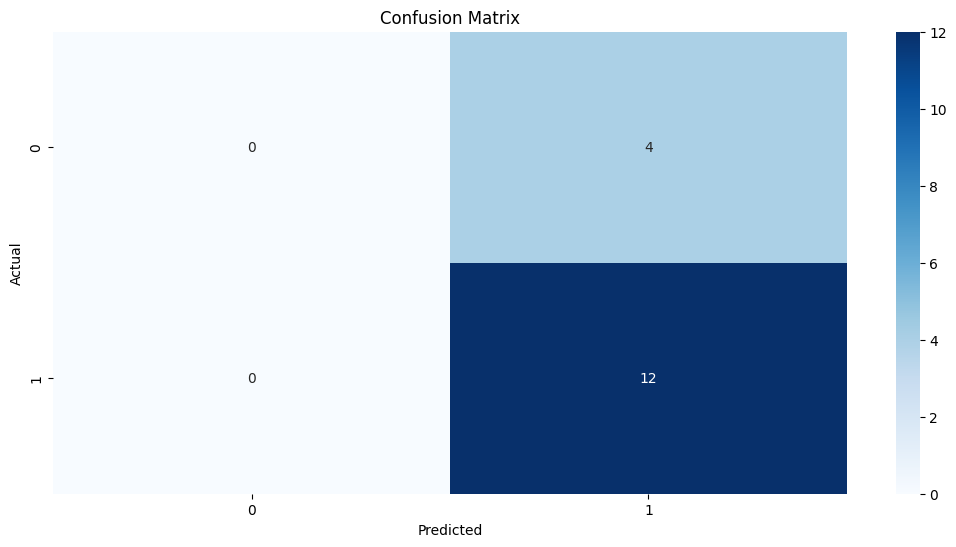

In [52]:
# Logistic Regression
logreg = linear_model.LogisticRegression()
kfold = model_selection.KFold(n_splits=10, random_state=12, shuffle=True)
actual_classes, predicted_classes, _ = cross_validation_(model = logreg, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.64      0.58      0.61        12

    accuracy                           0.44        16
   macro avg       0.32      0.29      0.30        16
weighted avg       0.48      0.44      0.46        16



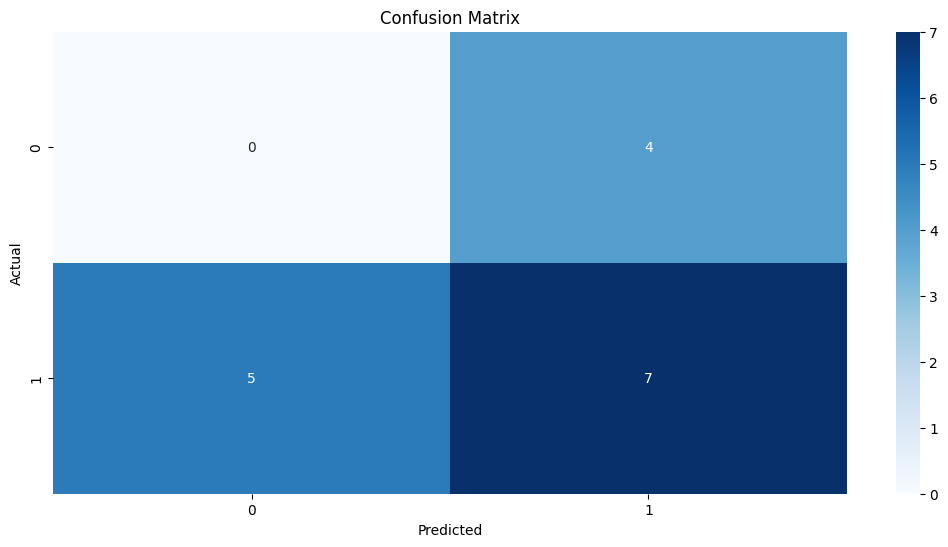

In [53]:
# KNN
knn_mod = neighbors.KNeighborsClassifier() 
actual_classes, predicted_classes, _ = cross_validation_(model = knn_mod, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      1.00      0.86        12

    accuracy                           0.75        16
   macro avg       0.38      0.50      0.43        16
weighted avg       0.56      0.75      0.64        16



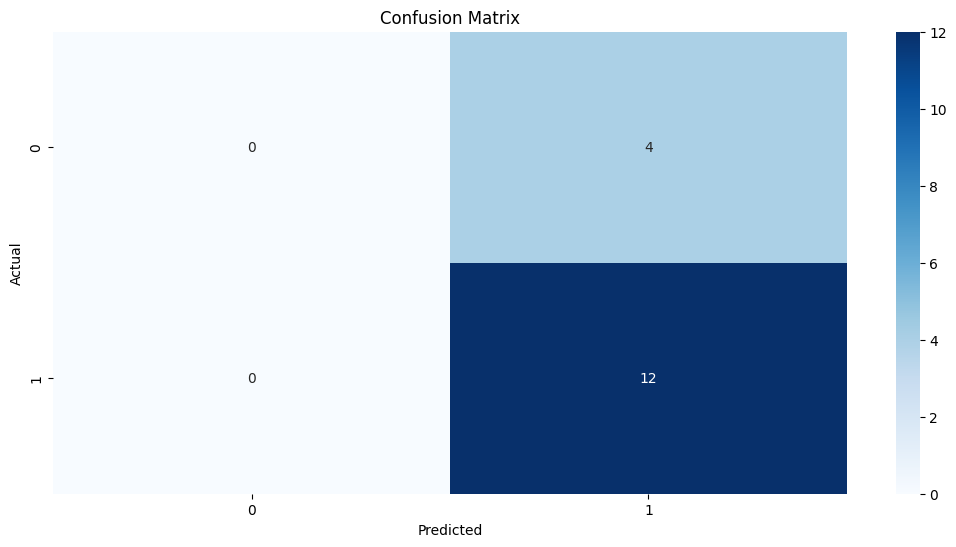

In [54]:
# Decision Tree
tree_mod = tree.DecisionTreeClassifier()
actual_classes, predicted_classes, _ = cross_validation_(model = tree_mod, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      1.00      0.86        12

    accuracy                           0.75        16
   macro avg       0.38      0.50      0.43        16
weighted avg       0.56      0.75      0.64        16



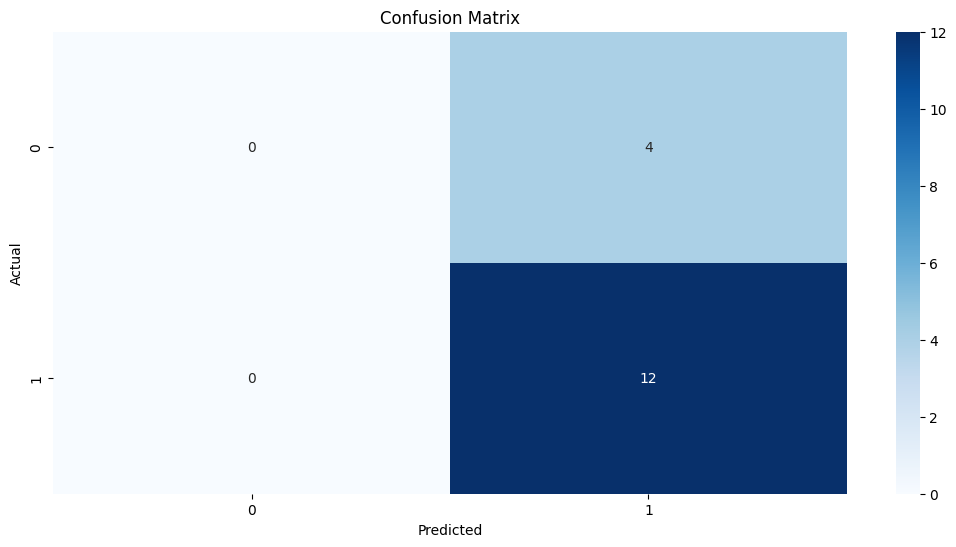

In [55]:
# XGBOOST
xgb_clf = xgb.XGBClassifier() 
actual_classes, predicted_classes, _ = cross_validation_(model = xgb_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      1.00      0.86        12

    accuracy                           0.75        16
   macro avg       0.38      0.50      0.43        16
weighted avg       0.56      0.75      0.64        16



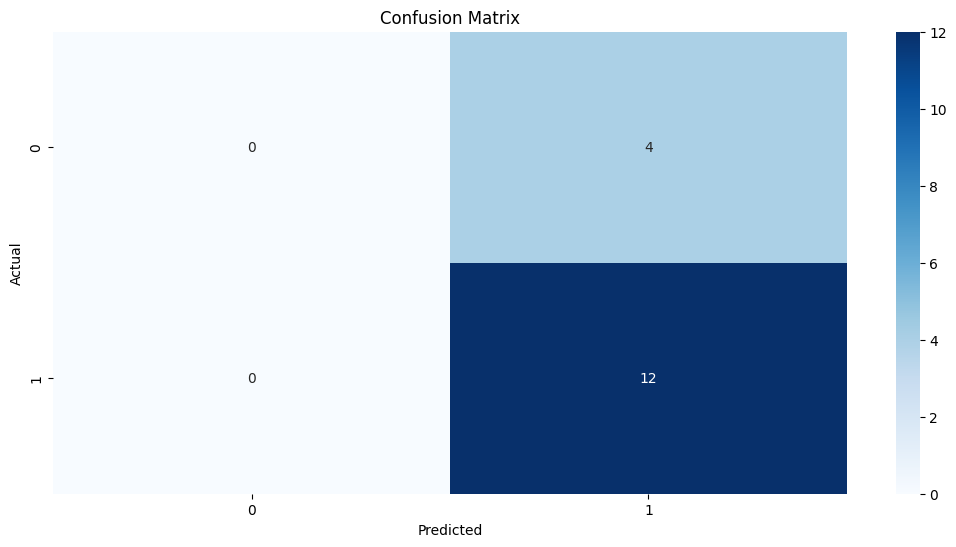

In [56]:
# Random Forest
rf_clf = ensemble.RandomForestClassifier()
actual_classes, predicted_classes, _ = cross_validation_(model = rf_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      1.00      0.86        12

    accuracy                           0.75        16
   macro avg       0.38      0.50      0.43        16
weighted avg       0.56      0.75      0.64        16



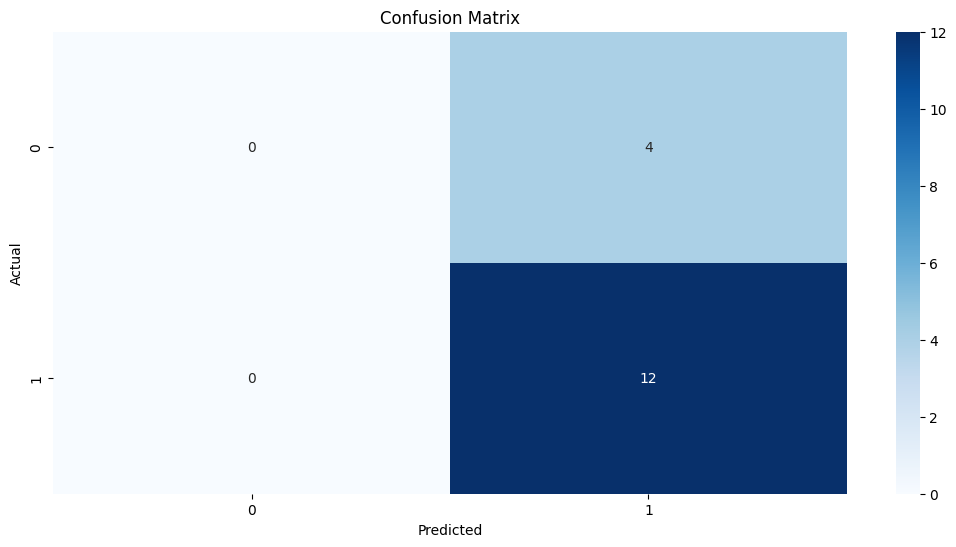

In [57]:
# SVM
svm_clf = svm.SVC() 
actual_classes, predicted_classes, _ = cross_validation_(model = rf_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

### Top 3 models
- Logistic Regression
- XGBoost
- SVM
- Random Forest

## Next Steps
- Parameter optimization for top 3 models
- Precision/Recall for evaluation
- Train a NN (Transfer learning?)
- Choose model based on accuracy, explainability, and computation time
- "Deploy" the model to HuggingFace 

In [58]:
# models = []
# models.append(('LR', linear_model.LogisticRegression()))
# models.append(('KNN', neighbors.KNeighborsClassifier()))
# models.append(('CART', tree.DecisionTreeClassifier()))
# models.append(('XGBOOST', xgb.XGBClassifier()))
# models.append(('RF', ensemble.RandomForestClassifier()))
# models.append(('SVM', svm.SVC()))

# # evaluate each model in turn
# results = []
# names = []
# scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
# # result_df = pd.DataFrame()
# dfs = []
# for name, model in models:
# 	cv_results = model_selection.cross_validate(model, X_train_transformed, y_train, cv=kfold, scoring=scoring)
# 	# results.append(cv_results)
# 	# names.append(name)

# 	# this_df = pd.DataFrame(cv_results)
# 	# this_df['model'] = name
# 	# dfs.append(this_df)

# 	# result_df.append({"name": name, "results": cv_results}, ignore_index=True)
# 	# msg = f"{name}: {round(cv_results.mean(), 2)} \u00B1 {round(cv_results.std(), 2)}"
# 	# print(msg)
# # boxplot algorithm comparison
# # fig = plt.figure()
# # fig.suptitle('Algorithm Comparison')
# # ax = fig.add_subplot(111)
# # sns.boxplot(results)
# # ax.set_xticklabels(names)
# # plt.show()

## PARAMETER OPTIMIZATION

In [59]:

estimators = [("dim_reducer", decomposition.PCA()), ("model", linear_model.LogisticRegression())]
cachedir = mkdtemp()
pipe = pipeline.Pipeline(estimators, memory=cachedir)

params = [
    {
        "dim_reducer" :[decomposition.PCA(), decomposition.KernelPCA()], 
        "model" : [linear_model.LogisticRegression()],
        "dim_reducer__n_components": [0.5, 0.7, 0.9, 0.95],
        "model__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
        "model__penalty": ['l1','l2'], 
        "model__C": [0.001, 0.01, 0.1, 1, 10, 100]     
    }
]

grid = model_selection.GridSearchCV(pipe, params, cv = 10)


In [60]:
fitted_grid = grid.fit(X_train_transformed, y_train)
# fitted_grid.best_params_

ValueError: Found input variables with inconsistent numbers of samples: [16, 1624]

In [61]:
X_train_transformed.shape

(16, 16)

In [62]:
y_train.shape

(1624,)